# FINAL PROJECT SUBMISSION

Student name: Mohammed Siddiqui

project review date/time: 5/23/2021 8:15 am CST

Instructor name: Claude Fried



# Business Problem

* The Urban League of Chicago would like to help low income clients choose loans for long term mortgages
* Which type of loan is recommended for each client?
* When is the best time to take a loan?


# 1. Import and Cleaning

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (16, 10)

import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import optimizers
import tensorflow as tf
tf.random.set_seed(389)

import warnings
warnings.filterwarnings('ignore')




tf.random.set_seed(389)

## 1.1 Data Sources

Data has been sourced from the Federal Reserve Bank of St. Louis: FRED.org

## 1.2 Import

In [2]:
df = pd.read_csv('data/treasury_rates.csv')
df_mort =pd.read_csv('data/mort_30.csv')

# 1.3 Clean Data

In [3]:
df

,DATE,DGS6MO,DGS1,DGS2,DGS5,DGS10,DGS30
0,1986-02-18,7.42,7.56,7.96,8.28,8.64,8.89
1,1986-02-19,7.51,7.67,8.06,8.37,8.7,8.92
2,1986-02-20,7.54,7.68,8.05,8.39,8.67,8.88
3,1986-02-21,7.42,7.56,7.93,8.24,8.48,8.73
4,1986-02-24,7.41,7.53,7.86,8.2,8.39,8.61
...,...,...,...,...,...,...,...
9188,2021-05-07,0.04,0.05,0.14,0.77,1.6,2.28
9189,2021-05-10,0.04,0.05,0.16,0.8,1.63,2.32
9190,2021-05-11,0.04,0.05,0.16,0.8,1.64,2.35
9191,2021-05-12,0.04,0.05,0.16,0.87,1.69,2.4


These are the Daily Treasury Yeild Curve Rates for Constant Maturity Treasury Bills

Maturity Lengths are as follows:

* DGS6MO: 6 Months
* DGS1: 1 Year
* DGS2: 2 Years
* DGS5: 5 Years
* DGS10: 10 Years
* DGS 30: 30 Years

In this project, we will concentrate on modeling and predicting the 10-Year Bill

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9193 entries, 0 to 9192
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    9193 non-null   object
 1   DGS6MO  9193 non-null   object
 2   DGS1    9193 non-null   object
 3   DGS2    9193 non-null   object
 4   DGS5    9193 non-null   object
 5   DGS10   9193 non-null   object
 6   DGS30   9193 non-null   object
dtypes: object(7)
memory usage: 502.9+ KB


In [5]:
df[df['DGS10'] == '.']

,DATE,DGS6MO,DGS1,DGS2,DGS5,DGS10,DGS30
28,1986-03-28,.,.,.,.,.,.
69,1986-05-26,.,.,.,.,.,.
98,1986-07-04,.,.,.,.,.,.
139,1986-09-01,.,.,.,.,.,.
169,1986-10-13,.,.,.,.,.,.
...,...,...,...,...,...,...,...
9072,2020-11-26,.,.,.,.,.,.
9093,2020-12-25,.,.,.,.,.,.
9098,2021-01-01,.,.,.,.,.,.
9109,2021-01-18,.,.,.,.,.,.


* Date needs to be set to datetime
* Other values should be floats.  I suspect this is because the null values are '.'

In [6]:
df_mort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          1736 non-null   object 
 1   MORTGAGE30US  1736 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.2+ KB


* MORTGAGE30US: Interest rates for 30 Year Mortgages
* Just need to change the Date to datetime

In [7]:
df_mort[df_mort['MORTGAGE30US']== '.']

,DATE,MORTGAGE30US


* Because this data is quarterly, there are no missing values for holidays

In [8]:
# Convert both DATE columns to datetime

df['DATE'] = pd.to_datetime(df['DATE'])
df_mort['DATE'] = pd.to_datetime(df_mort['DATE'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9193 entries, 0 to 9192
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    9193 non-null   datetime64[ns]
 1   DGS6MO  9193 non-null   object        
 2   DGS1    9193 non-null   object        
 3   DGS2    9193 non-null   object        
 4   DGS5    9193 non-null   object        
 5   DGS10   9193 non-null   object        
 6   DGS30   9193 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 502.9+ KB


In [10]:
df.head(20)

,DATE,DGS6MO,DGS1,DGS2,DGS5,DGS10,DGS30
0,1986-02-18,7.42,7.56,7.96,8.28,8.64,8.89
1,1986-02-19,7.51,7.67,8.06,8.37,8.7,8.92
2,1986-02-20,7.54,7.68,8.05,8.39,8.67,8.88
3,1986-02-21,7.42,7.56,7.93,8.24,8.48,8.73
4,1986-02-24,7.41,7.53,7.86,8.2,8.39,8.61
5,1986-02-25,7.43,7.59,7.89,8.21,8.4,8.6
6,1986-02-26,7.42,7.57,7.88,8.07,8.36,8.54
7,1986-02-27,7.36,7.48,7.72,7.91,8.15,8.32
8,1986-02-28,7.36,7.43,7.71,7.91,8.13,8.27
9,1986-03-03,7.3,7.35,7.55,7.76,7.99,8.16


* The missing data here is from Christmas and New Years, which makes sense since the market is closed.
* I'll fill in the missing data from the value of the previous day.

In [11]:
# Forward Fill the missing values
df = df.replace('.', np.nan).ffill(axis=0)

In [12]:
df[df['DGS10'] == '.']

,DATE,DGS6MO,DGS1,DGS2,DGS5,DGS10,DGS30


* Looks good.

In [13]:
# Renaming columns for easier readability

df = df.rename(columns={'DATE': 'date',
                        'DGS6MO': 'mo_6',
                        'DGS1': 'yr_1',
                        'DGS2': 'yr_2',
                        'DGS5': 'yr_5',
                        'DGS10': 'yr_10',
                        'DGS30': 'yr_30'})

df_mort = df_mort.rename(columns={'DATE': 'date',
                                  'MORTGAGE30US': 'mort_30'})

In [14]:
# Set the dates as the index

df.set_index('date', inplace=True)
df_mort.set_index('date', inplace=True)


We'll begin our data in 1989 because of consistent monetary policy during the time period.

This covers all administrations after Reagan.

In [15]:
df = df['1989':]
df_mort = df_mort['1989':]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8444 entries, 1989-01-02 to 2021-05-13
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mo_6    8444 non-null   object
 1   yr_1    8444 non-null   object
 2   yr_2    8444 non-null   object
 3   yr_5    8444 non-null   object
 4   yr_10   8444 non-null   object
 5   yr_30   8444 non-null   object
dtypes: object(6)
memory usage: 461.8+ KB


* Need to make these columns into floats

In [17]:
df =df.iloc[:,0:] = df.iloc[:,0:].astype('float')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8444 entries, 1989-01-02 to 2021-05-13
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mo_6    8444 non-null   float64
 1   yr_1    8444 non-null   float64
 2   yr_2    8444 non-null   float64
 3   yr_5    8444 non-null   float64
 4   yr_10   8444 non-null   float64
 5   yr_30   8444 non-null   float64
dtypes: float64(6)
memory usage: 461.8 KB


* Looks good

In [19]:
df_mort.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1690 entries, 1989-01-06 to 2021-05-20
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mort_30  1690 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB


* This was already a float

Overall, this data was quite clean and only needed some minor cleaning.

# 2. Exploratory Data Analysis

In [20]:
df.describe()

,mo_6,yr_1,yr_2,yr_5,yr_10,yr_30
count,8444.000000,8444.000000,8444.000000,8444.000000,8444.000000,8444.000000
mean,2.970870,3.091595,3.377055,3.959298,4.485083,5.017933
std,2.497012,2.495160,2.504342,2.322941,2.111447,1.902097
min,0.020000,0.050000,0.090000,0.190000,0.520000,0.990000
25%,0.380000,0.520000,0.910000,1.790000,2.610000,3.200000
50%,2.490000,2.600000,3.025000,3.850000,4.370000,4.930000
75%,5.162500,5.260000,5.520000,5.850000,6.060000,6.360000
max,9.690000,9.850000,9.920000,9.750000,9.530000,9.310000


* I only care about yr_10.
* Nothing too crazy, but Standard Deviation is quite high.

# Short Term Bill

Taking a look at this is important beause because short term yields are a good indicator for short term interest rates.

Adjustable rate mortgages are based on the Federal Reserve Target interest rate
    * The 6-Month yields show this quite well visually

Text(0.5, 0, 'Date')

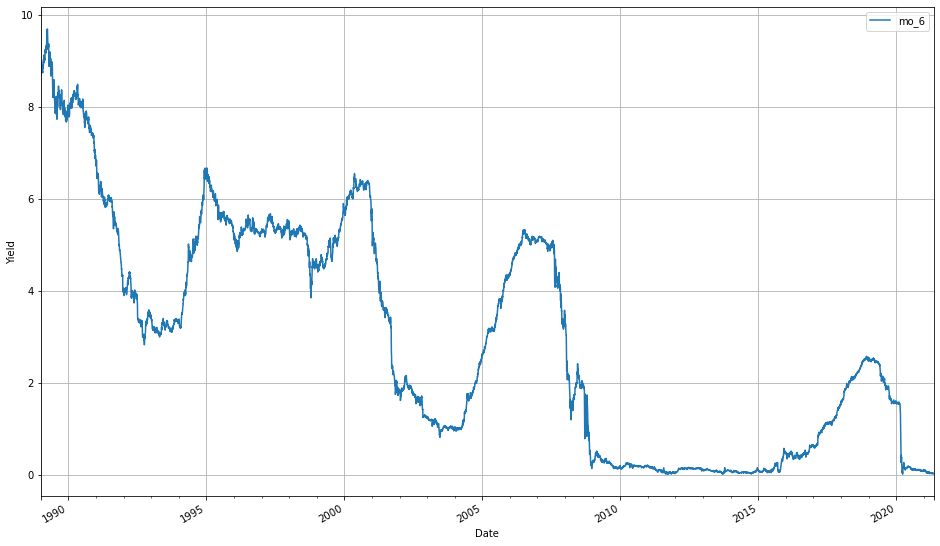

In [21]:
df[['mo_6']].plot(subplots=True, grid=True)
plt.ylabel('Yield')
plt.xlabel('Date')

There is quite a bit of volatitlity here, but these are based on conscious decisions by the Fed.

Their priority is keeping the annual inflation rate under 2%

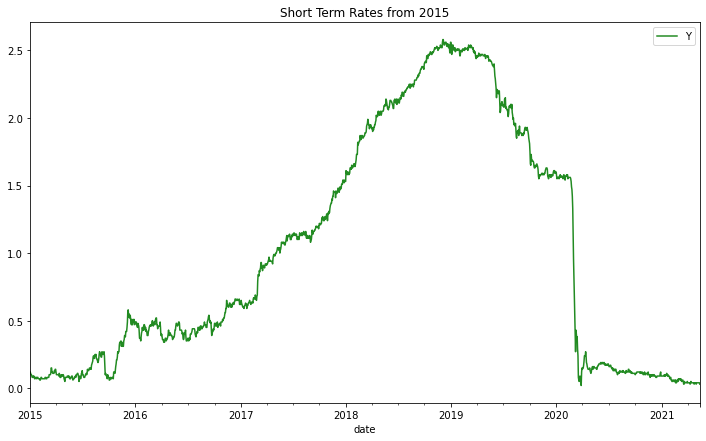

In [22]:
plt.figure(figsize=(12,7))
df['mo_6']['2015':].plot(color='forestgreen', label='Short Term Rates')
plt.title('Short Term Rates from 2015')
plt.xlabel
plt.legend('Yields')

* The Fed began to raise target rates in late 2015 in order to curb inflation by contracting money supply.
* In late 2018, interest rates began to lower again since the last policy went too far.
* The sharp decline in 2020 is due to the unprecidented issues brought on by the Coronavirus pandemic.
* 

## Long Term(10 Year) Bill

Text(0.5, 0, 'Date')

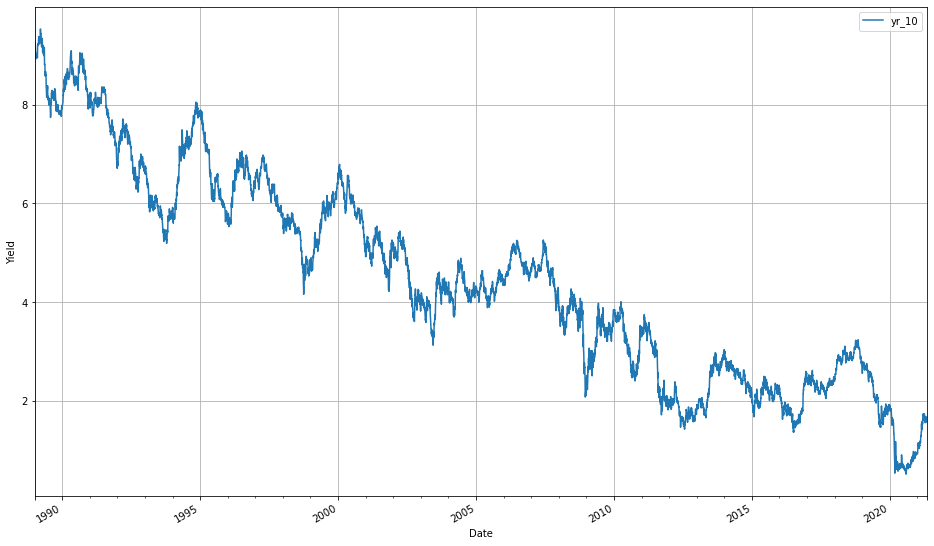

In [23]:
df[['yr_10']].plot(subplots=True, grid=True)
plt.ylabel('Yield')
plt.xlabel('Date')

* I expect thsi downward trend to throw off some models that aren't as sophisticated.

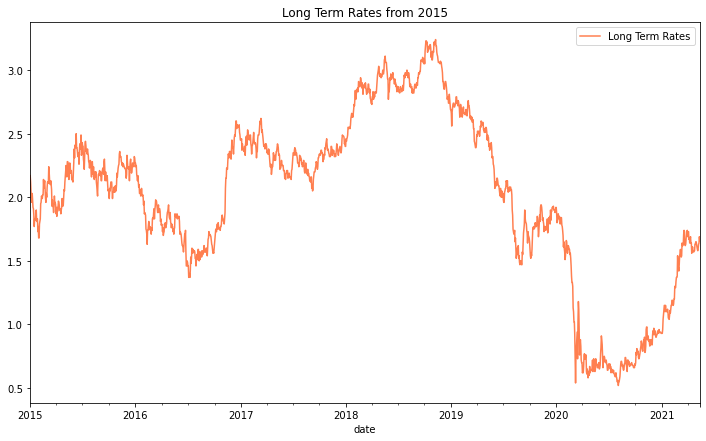

In [24]:
plt.figure(figsize=(12,7))
df['yr_10']['2015':].plot(color='coral', label='Long Term Rates')
plt.title('Long Term Rates from 2015')
plt.legend()

* Still see a Coronavirus dip, but it started to go up again in mid 2020
    * Seems to have stabilized some in the last few months.

(array([1630., 2217., 2304., 1521.,  772.]),
 array([0.52 , 2.322, 4.124, 5.926, 7.728, 9.53 ]),
 <BarContainer object of 5 artists>)

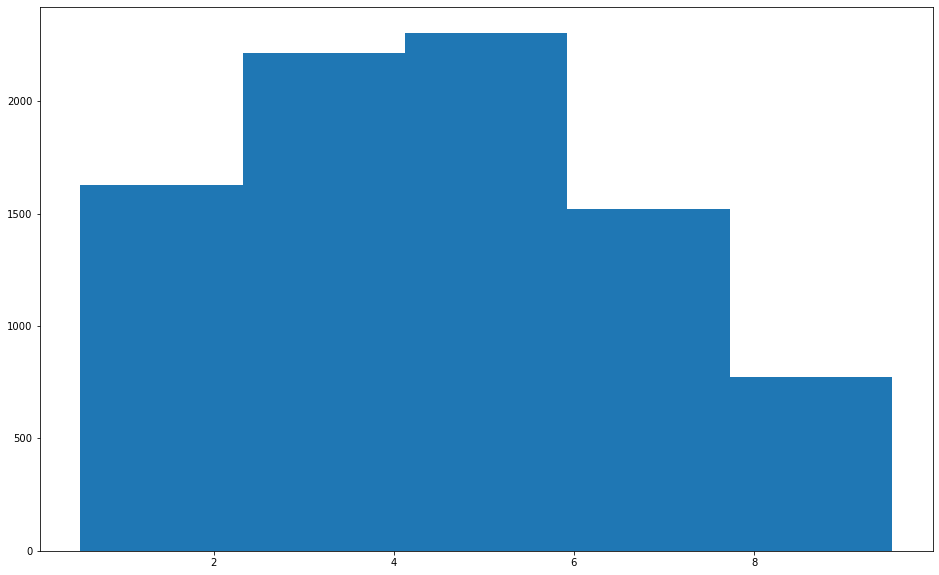

In [25]:
plt.hist(df['yr_10'], bins=5)

* This is normal enough that we don't need to change too much.

In [26]:
# Resample to the beggining of each month

ys_month = df['yr_10'].resample('MS').mean()
ys_std = df['yr_10'].resample('MS').std()
mort_30 = df_mort['mort_30'].resample('MS').mean()

In [27]:
m_extra =pd.DataFrame(mort_30).join(ys_month, on=mort_30.index)

Text(0.5, 1.0, '30 Year Mortgage Interest Rate and 10 Year T-Bill Yeild')

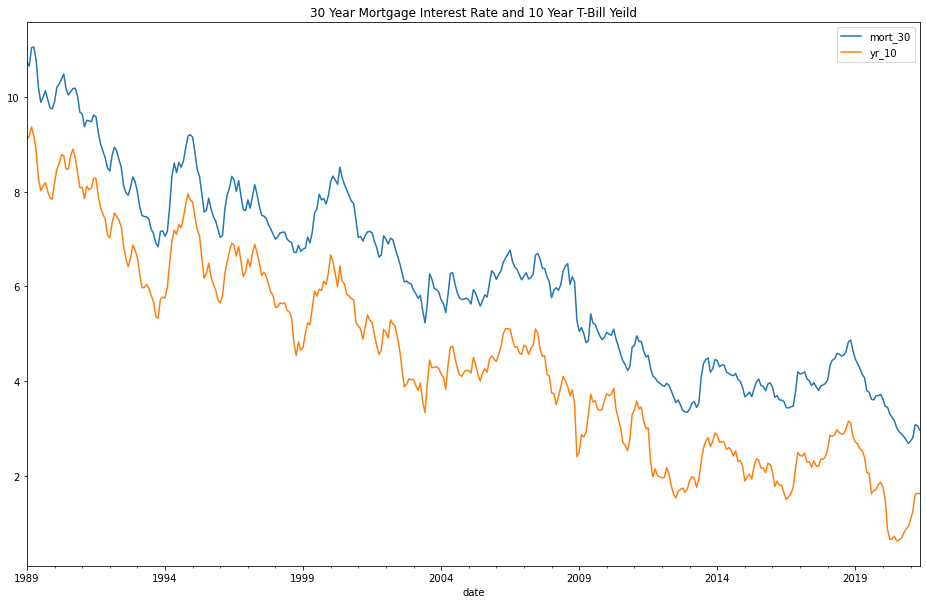

In [28]:
m_extra.plot()
plt.title('30 Year Mortgage Interest Rate and 10 Year T-Bill Yeild')

Text(0.5, 1.0, 'Visual Look for Correlation')

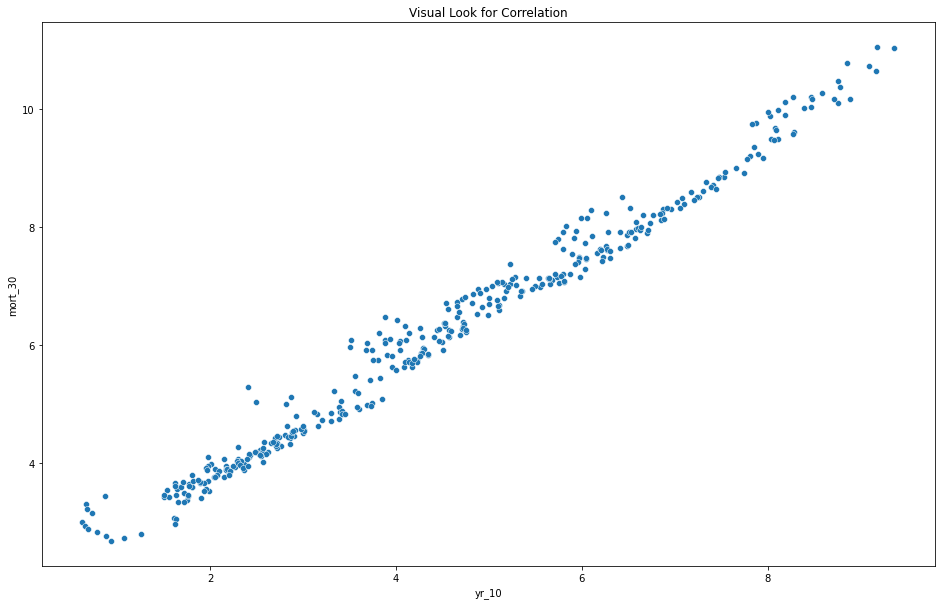

In [29]:
sns.scatterplot(data=m_extra, x='yr_10', y='mort_30')
plt.title('Visual Look for Correlation')

Looks pretty strong.

In [30]:
m_extra.corr()

,mort_30,yr_10
mort_30,1.000000,0.991118
yr_10,0.991118,1.000000


* Correlation of 0.99 is obviously very high
* Shows that these bonds yields are a great predictor for mortgage interest rates.

We knew the above, but it's always good to double check.

## Stationarity

The ARMA model assumes stationarity, so let's check for that.

In [31]:
roll_mean = df['yr_10'].rolling(window=90, center=False).mean()
roll_std= df['yr_10'].rolling(window=90, center=False).std()

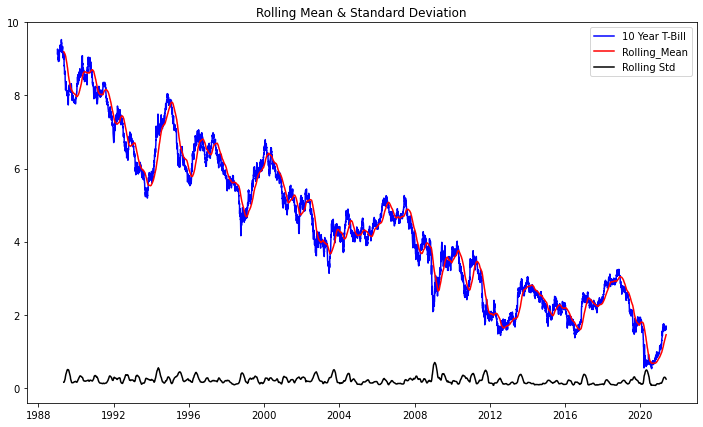

In [32]:
fig = plt.figure(figsize=(12,7))
plt.plot(df['yr_10'], color='blue', label='10 Year T-Bill')
plt.plot(roll_mean, color='red', label='Rolling_Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

* The standard deviation doesn't seem to be too off.
* It's really hard to make a judgement based on this.

In [33]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['yr_10'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                   -1.843206
p-value                           0.359232
#Lags Used                       22.000000
Number of Observations Used    8421.000000
Critical Value (1%)              -3.431127
Critical Value (5%)              -2.861883
Critical Value (10%)             -2.566953
dtype: float64


* p-value is above 0.05, so we are not stationary

* Let's subract the rolling mean from the values

In [34]:
# Get the difference between the data and the rolling mean and make it monthly

minus_rm = (df['yr_10'] - roll_mean).dropna().resample('MS').mean()


In [35]:

#ys_std = (df['yr_10'] - roll_mean).dropna().resample('MS').std()
ys_orig = np.array(ys_month)

In [36]:
rm_monthly =roll_mean.resample('MS').mean()


In [37]:
dftest = adfuller(minus_rm)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -1.085662e+01
p-value                        1.482033e-19
#Lags Used                     1.000000e+00
Number of Observations Used    3.830000e+02
Critical Value (1%)           -3.447540e+00
Critical Value (5%)           -2.869116e+00
Critical Value (10%)          -2.570806e+00
dtype: float64


* We are definitely stationary now.  Let's plot this.

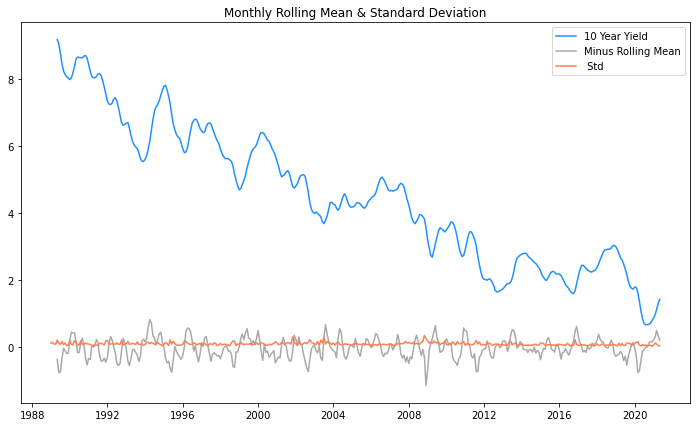

In [38]:
fig = plt.figure(figsize=(12,7))
plt.plot(rm_monthly, color='dodgerblue', label='10 Year Yield')
plt.plot(minus_rm, color='darkgrey', label='Minus Rolling Mean')
plt.plot(ys_std, color='coral', label = ' Std')
plt.legend(loc='best')
plt.title('Monthly Rolling Mean & Standard Deviation')
plt.show(block=False)

* Nothing looks particularly off here.

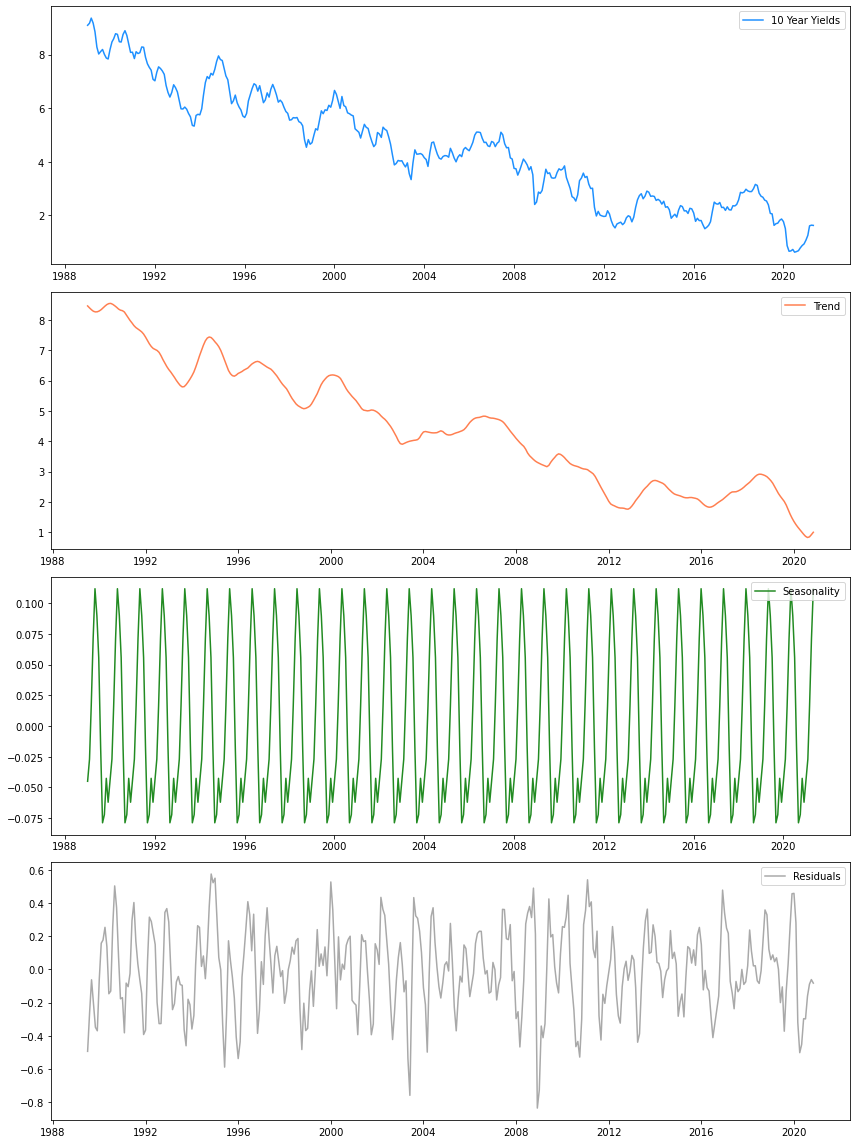

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(ys_month)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,16))
plt.subplot(411)
plt.plot(ys_month, label='10 Year Yields', color='dodgerblue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='coral')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='forestgreen')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkgrey')
plt.legend(loc='best')
plt.tight_layout()

* We definitely have seasonality, which we couldn't see before.
* The trend line is basically the rolling mean line
* The residual plot here is pretty much what we have set as minus_rm

Text(0, 0.5, 'Rate minus Average')

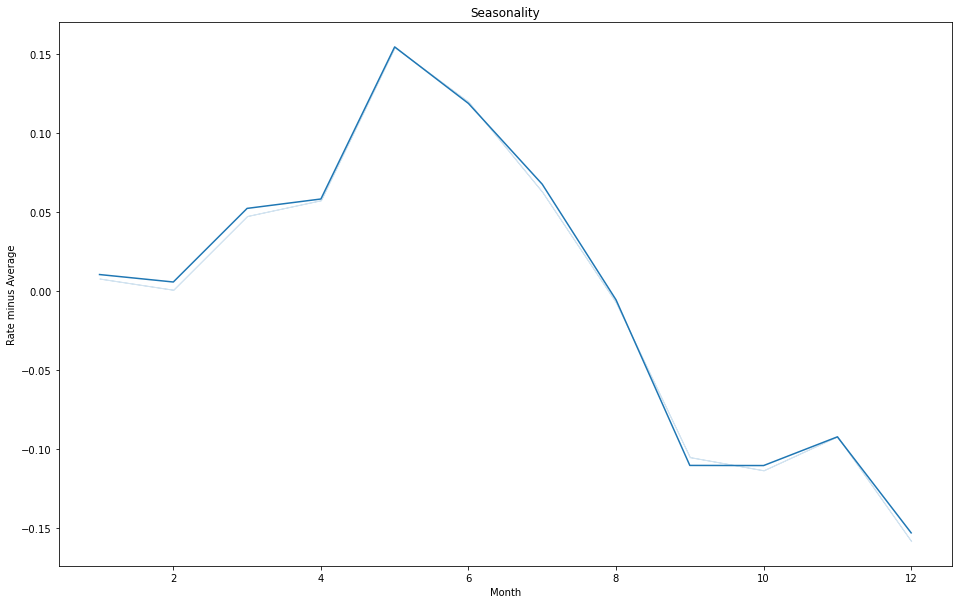

In [40]:
sns.lineplot(x=df.index.month, y=(df['yr_10']-df['yr_10'].mean()), ci=False)
plt.title('Seasonality')
plt.xlabel('Month')
plt.ylabel('Rate minus Average')


* We notice a sharp drop here from May to September

In [41]:
per_ch =(ys_month.shift(-1)-ys_month)

Text(0, 0.5, 'Rate Change')

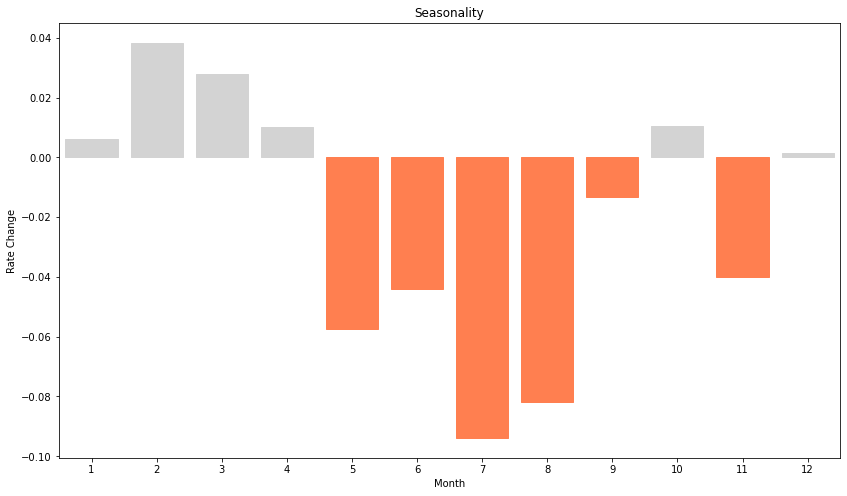

In [42]:
plt.figure(figsize=(14,8))
ax = sns.barplot(x=per_ch.index.month, y=per_ch, ci=False)

for bar in ax.patches:
    if bar.get_height() <0:
        bar.set_color('coral')    
    else:
        bar.set_color('lightgrey')

plt.title('Seasonality')
plt.xlabel('Month')
plt.ylabel('Rate Change')

* We see rate drops May through September
* November also has a negative change.

# 3. Iterative Modeling

## 3.1 ARMA

### Train Test Split

* Because we're dealing with time series, we need our train and test in chronological order
* We'll do this manually
* Will use an 80:20 split

In [43]:
twenty = int(len(minus_rm) * 0.2)
train, test = minus_rm[:-twenty], minus_rm[-twenty:]

In [44]:
print(len(train))
print(len(test))

308
77


### Preparation

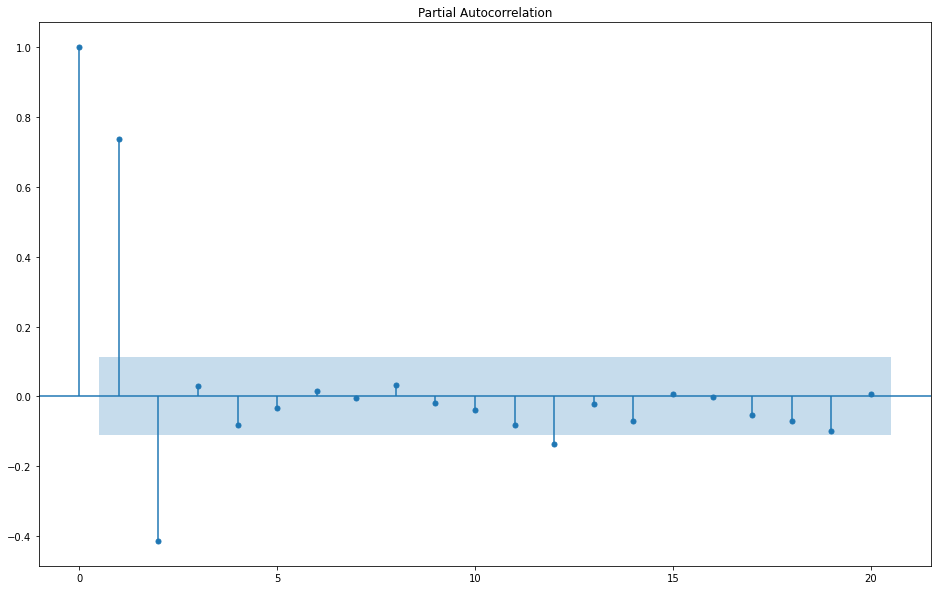

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(train, lags=20);

* This gives us the q value representing the MA.
* We're seeing significance on month 1, 2 and 12
* The values for the 2nd and 12 month behind are negative.
* I'd probably choose a q value of 1 or 2

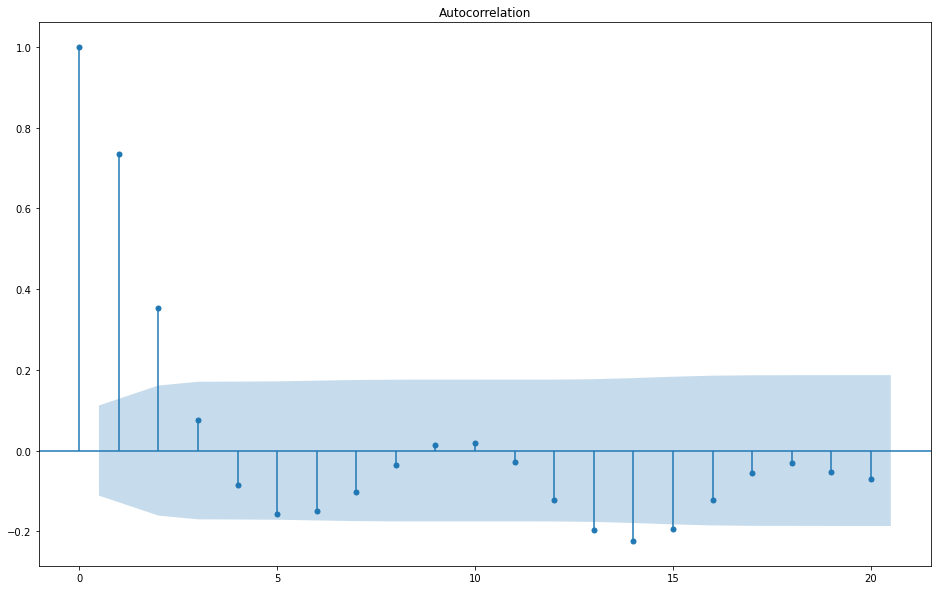

In [46]:
plot_acf(train, lags=20);

* We can get the p for the AR part of the model here
* Sharp decline immediately indicates that we're stationary
* p of 2 looks good here
* There are significant values 13,14 and 15 months behind

* Based on this, it looks like the p and q would be 2,1 or 2,2
* It's possible that the cyclic nature of the series is showing itself again.

In [47]:
# Import ARMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm


In [48]:
run_cv = 0

if run_cv:

    p = q = (0,1,2,3)
    
    combo, value = (None, None)
    
    for ar in p:
        for ma in q:
            try:
                model = ARMA(np.asarray(train), order=(ar, ma)).fit()
                print('Combo:', (ar, ma),'AIC:', model.aic)

                if value is None or model.aic < value:
                    combo, value = ((ar, ma), model.aic)
                    print(f'\tBest Parameters Updated')
            except ValueError:
                pass
            
    print(f'\n{"*"*20}\nOptimal ARMA order: {combo}') 


* These are all so close together.
* Best performance is for (3,2), but (2,2) is almost the same
* (1,1) has pretty good results considering the number of features

In [49]:
def run_arma(trn, tst, p, q):
    ''' Run ARMA model and return the model, predictions and mean average error.
        Prints model summary
        Prints mean average error for the test data

        Parameters:
        trn = Train data
        tst = Tst data
        p = p, to put into model
        q = q, to put into model

        Returns:
        model = fitted model
        pred = predictions for the trainig 
    '''
    model = ARMA(np.asarray(trn), order=(p,q)).fit()
    print(model.summary())

    pred = model.forecast(steps=77)[0]

    mae =  mean_absolute_error(tst, pred)


    print(f'Mean Absolute Error for Test: {mae}')


    return model, pred, mae



### 3.1.1 ARMA Model 1

In [50]:
model_1, pred_1, mae_1 =run_arma(train, test, 2,2)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  308
Model:                     ARMA(2, 2)   Log Likelihood                  82.674
Method:                       css-mle   S.D. of innovations              0.184
Date:                Sun, 23 May 2021   AIC                           -153.348
Time:                        13:05:31   BIC                           -130.968
Sample:                             0   HQIC                          -144.399
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.003    -14.673      0.000      -0.046      -0.035
ar.L1.y        1.5587      0.053     29.444      0.000       1.455       1.662
ar.L2.y       -0.6156      0.053    -11.612      0.0

* All the p-values are below 0.05
* Concerned about the const being weighted too heavily
* Let's see how other ARMA models do in comparison

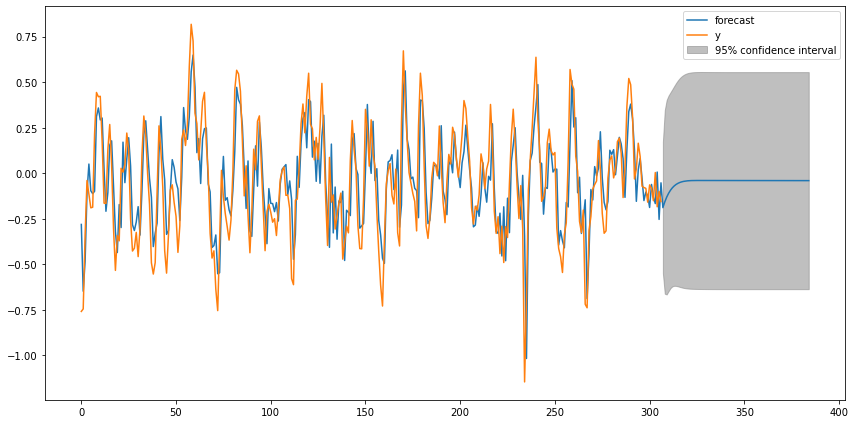

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
model_1.plot_predict(1, len(train)+77, ax=ax)
fig.tight_layout()

* This model trails essentially reverts to the const of -.0407
* There is very little value here for long term projections

### 3.1.2 ARMA Model 2

In [52]:
model_2, pred_2, mae_2 =run_arma(train, test, 3,2)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  308
Model:                     ARMA(3, 2)   Log Likelihood                  83.689
Method:                       css-mle   S.D. of innovations              0.183
Date:                Sun, 23 May 2021   AIC                           -153.378
Time:                        13:05:32   BIC                           -127.268
Sample:                             0   HQIC                          -142.938
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.003    -13.461      0.000      -0.047      -0.035
ar.L1.y        1.7700      0.159     11.151      0.000       1.459       2.081
ar.L2.y       -1.0054      0.278     -3.619      0.0

* ar.L3 and ma.l2 have high p-values
* MAE is lower though

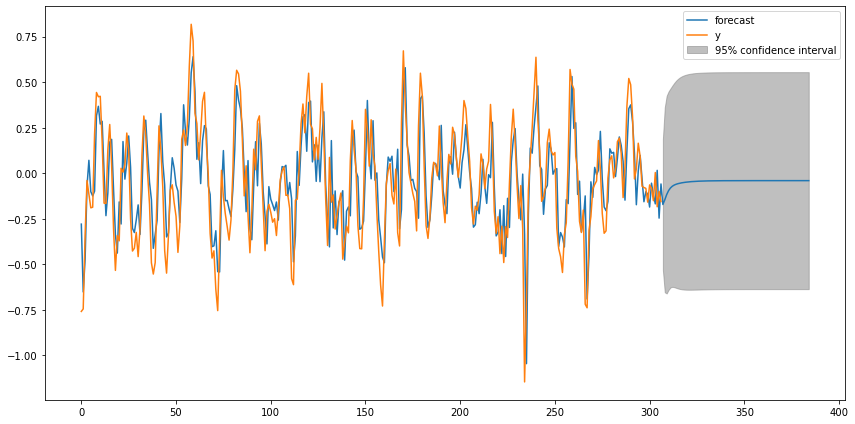

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
model_2.plot_predict(1, len(train)+77, ax=ax)
fig.tight_layout()

### 3.3.3 ARMA Model 3

In [54]:
model_3, pred_3, mae_3 =run_arma(train, test, 1, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  308
Model:                     ARMA(1, 1)   Log Likelihood                  73.745
Method:                       css-mle   S.D. of innovations              0.190
Date:                Sun, 23 May 2021   AIC                           -139.490
Time:                        13:05:33   BIC                           -124.570
Sample:                             0   HQIC                          -133.524
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0474      0.036     -1.307      0.191      -0.118       0.024
ar.L1.y        0.5665      0.055     10.254      0.000       0.458       0.675
ma.L1.y        0.4587      0.055      8.363      0.0

* constant p-value is an issue
* MAE is around the same as others, but this model is really simple

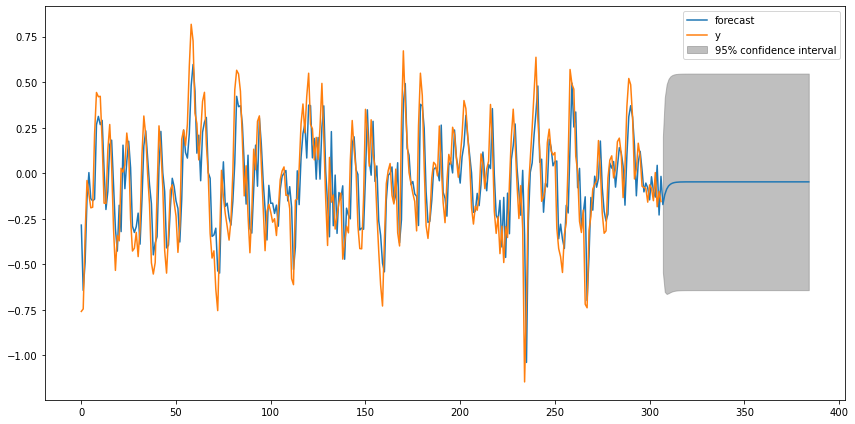

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
model_3.plot_predict(1, len(train)+77, ax=ax)
fig.tight_layout()

In [56]:
### Compare Test Predictions to Actual Values

In [57]:
pl_tst = pd.DataFrame(test)

In [58]:
pl_tst['pred'] = pred_1

In [59]:
pl_tst.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77 entries, 2015-01-01 to 2021-05-01
Freq: MS
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr_10   77 non-null     float64
 1   pred    77 non-null     float64
dtypes: float64(2)
memory usage: 1.8 KB


Text(0.5, 1.0, 'Predictions and True Values')

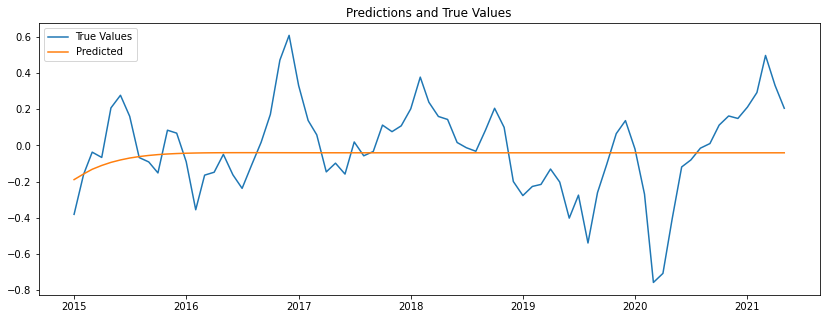

In [60]:
plt.figure(figsize=(14,5))
plt.plot(pl_tst['yr_10'], label='True Values')
plt.plot(pl_tst['pred'], label= 'Predicted')
plt.legend()
plt.title('Predictions and True Values')

* Starts off well enough, but it reverts to the mean and it's not very useful after that

## 3.2 ARIMA Model

In [61]:
from statsmodels.tsa.arima_model import ARIMA

### Non stationary train test split

In [62]:
twenty = int(len(ys_month) * 0.2)
train, test = ys_month[:-twenty], ys_month[-twenty:]

In [63]:
if run_cv:
    p = d = q = (0,1,2,3)
    
    
    combo, value = (None, None)
    for ar in p:
        for ma in q:
            for diff in d:
                try:
                    model = ARIMA(train, order=(ar, diff, ma)).fit()
                    print('Combo:', (ar, diff, ma),'AIC:', model.aic)
    
                    if value is None or model.aic < value:
                        combo, value = ((ar, diff, ma), model.aic)
                        print(f'\tBest Parameters Updated')
                except ValueError:
                    pass
            
    print(f'\n{"*"*20}\nOptimal ARIMA order: {combo}')

* Best combo is (1,1,2): -74.98
* (0,1,1): -65.84
* (3,1,3): -72.6

### ARIMA Model 1

In [64]:
arima_model_1 = ARIMA(train, order=(1,1,2)).fit()
arima_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.yr_10   No. Observations:                  311
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  42.491
Method:                       css-mle   S.D. of innovations              0.210
Date:                Sun, 23 May 2021   AIC                            -74.983
Time:                        13:05:34   BIC                            -56.284
Sample:                    02-01-1989   HQIC                           -67.509
                         - 12-01-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0202      0.002    -12.354      0.000      -0.023      -0.017
ar.L1.D.yr_10     0.8975      0.027     32.654      0.000       0.844       0.951
ma.L1.D.yr_10    -0.6240      0.056    -11.232      0.000      -0.733      -0.515
ma.L2.D.yr_10    -0.3760      0.055     -6.844      0.000      -0.484      -0.268
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1142           +0.0000j            1.1142            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -2.6596           +0.0000j            2.6596            0.5000
-----------------------------------------------------------------------------
"""

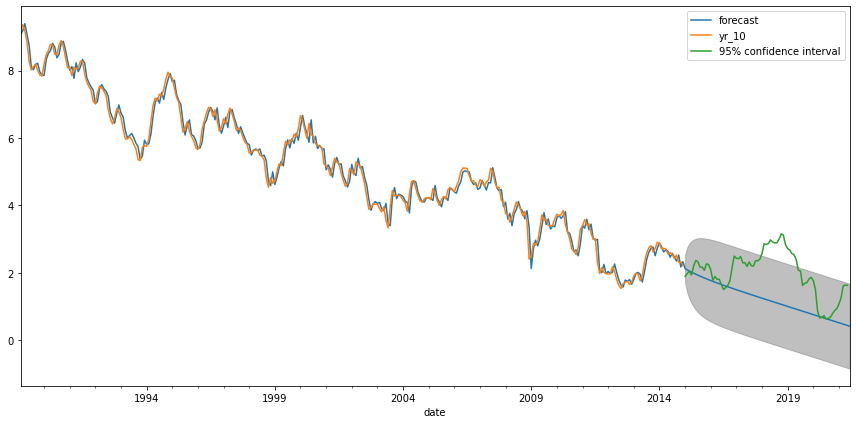

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))
arima_model_1.plot_predict(1, len(train)+77, ax=ax)
test.plot()
fig.tight_layout()

* This one is missing very low.  Just visually, this is out.

In [66]:
aripred =(arima_model_1.forecast(steps=len(test))[0])

In [67]:
def get_MAE(model, trn, tst):

    ''' Takes in model, train and test.
        Returns mean absolute error'''
        
    pred = model.predict(1, len(tst))
    mae_tst =  round(mean_absolute_error(tst, pred), 3)

    print(mae_tst)

In [68]:
get_MAE(arima_model_1, train, test)

2.003


* MAE is not good
* We expected this looking at the plot

### 3.2.2 ARIMA Model 2

In [69]:
arima_model_2 = ARIMA(train, order=(0,1,1)).fit()
arima_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.yr_10   No. Observations:                  311
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  35.919
Method:                       css-mle   S.D. of innovations              0.216
Date:                Sun, 23 May 2021   AIC                            -65.838
Time:                        13:05:35   BIC                            -54.619
Sample:                    02-01-1989   HQIC                           -61.354
                         - 12-01-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0223      0.016     -1.359      0.174      -0.054       0.010
ma.L1.D.yr_10     0.3414      0.055      6.158      0.000       0.233       0.450
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.9293           +0.0000j            2.9293            0.5000
-----------------------------------------------------------------------------
"""

* Extremely simple model that's only using MA.1

In [70]:
get_MAE(arima_model_2, train, test)

2.03


* This simpler model outperformed the more complicated one.

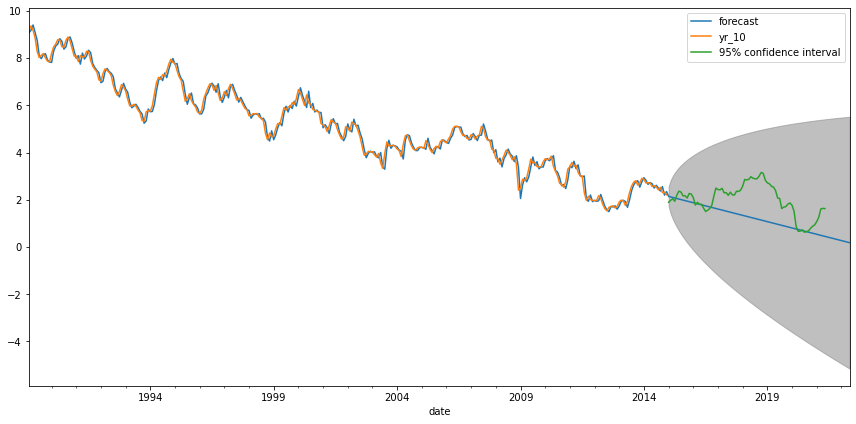

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
arima_model_2.plot_predict(1, 400, ax=ax)
test.plot()
fig.tight_layout()

* Still missing everything low, but the results are staying within the confidence interval.
* The downward prediction indicates that the const is having too much of an effect

## 3.3 SARIMA Model

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [73]:
if run_cv:
    p = q = (0, 1,2)
    d = 0

    pdq = [(ar, d, ma) for ar in p for ma in q]
    pdqs = [(c[0], d, c[2], 12) for c in pdq]

    # Iterate and try models.
    combo, value = (None, None)
    for pdq_combo in pdq:
        for pdqs_combo in pdqs:
            try:
                model = SARIMAX(
                np.asarray(train), 
                order=pdq_combo,
                seasonal_order=pdqs_combo,
                enforce_stationarity=False,
                enforce_invertibility=False
                )
                output = model.fit()

                if value is None or output.aic < value:
                    combo, value = ((pdq_combo, pdqs_combo), output.aic)
                    print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
            except ValueError:
                pass      
            
    print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

* Best is ((1, 0, 1), (0, 0, 0, 12))


### 3.3.1 SARIMA Model 1

In [74]:
 sari_model = SARIMAX(
    train, 
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
    ).fit()

print(sari_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  yr_10   No. Observations:                  312
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  36.154
Date:                Sun, 23 May 2021   AIC                            -66.308
Time:                        13:05:36   BIC                            -55.099
Sample:                    01-01-1989   HQIC                           -61.827
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9943      0.003    323.234      0.000       0.988       1.000
ma.L1          0.3408      0.048      7.109      0.000       0.247       0.435
sigma2         0.0463      0.003     15.231      0.0

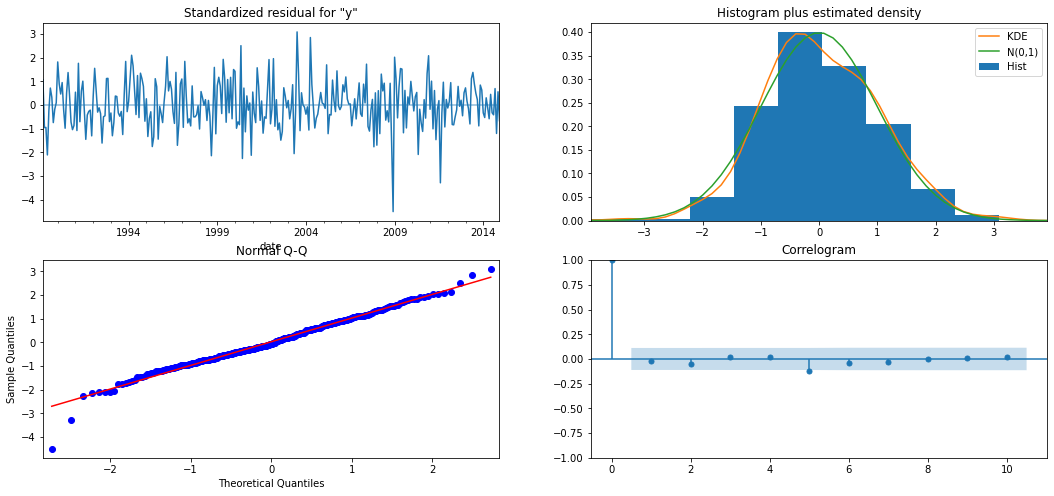

In [75]:
sari_model.plot_diagnostics(figsize=(18, 8))
plt.show()

* Our residual plot is has a normal distribution

In [76]:
sari_pred = sari_model.predict('2015', '2021-05-01')

In [77]:
mae_s1 =mean_absolute_error(test, sari_pred)
print(f'Test Mean Absolute Error: {mae_s1}')

Test Mean Absolute Error: 0.5355570229436238


In [78]:
sari_pred = sari_model.predict('1989', '2021-05-01', dynamic=False)
#sari_mse = round(mean_squared_error(test, sari_pred), 3)

In [79]:
sari_model.get_prediction(start=pd.to_datetime('2015-01-01'), 
                        end=pd.to_datetime('2021-05-01'), 
                        dynamic=False )

In [80]:
tst = pd.DataFrame(test)

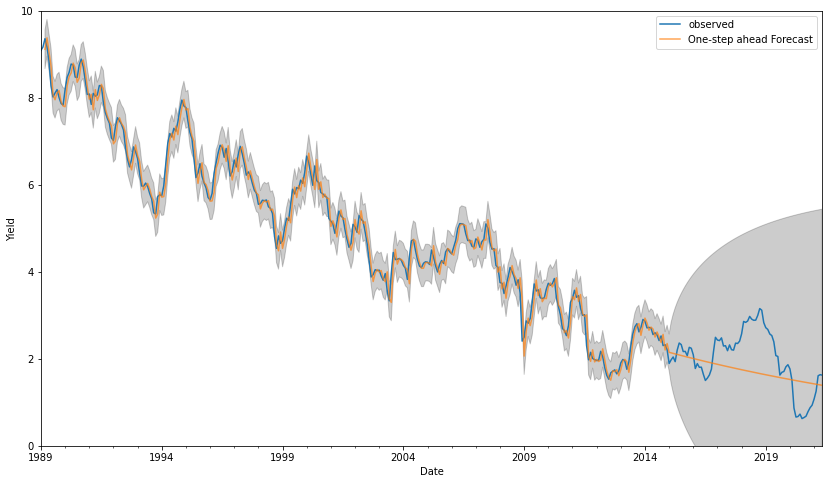

In [81]:
pred = sari_model.get_prediction(start=pd.to_datetime('1989-03-01'), 
                        end=pd.to_datetime('2021-05-01'), 
                        dynamic=False )

pred_ci = pred.conf_int()
ax = ys_month.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast',
alpha=.7, figsize=(14, 8))
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Yield')
plt.ylim(0, 10)
plt.legend()
plt.show()


* This certainly looks better than our ARIMA predictions

In [82]:
sari_pred = sari_model.predict('1989', '2021-05-01')

In [83]:
preds = sari_model.get_forecast( steps=77,
    dynamic=False)

### 3.3.2 SARIMA Model 2

In [84]:
 sari_model = SARIMAX(
    np.asarray(train), 
    order=(1, 1, 2),
    seasonal_order=(0, 1, 2, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
    ).fit()

print(sari_model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  312
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                  21.229
Date:                            Sun, 23 May 2021   AIC                            -30.459
Time:                                    13:05:46   BIC                             -8.824
Sample:                                         0   HQIC                           -21.773
                                            - 312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9035      0.036     25.013      0.000       0.833       0.974
ma.L1         -0.6636     58.875   

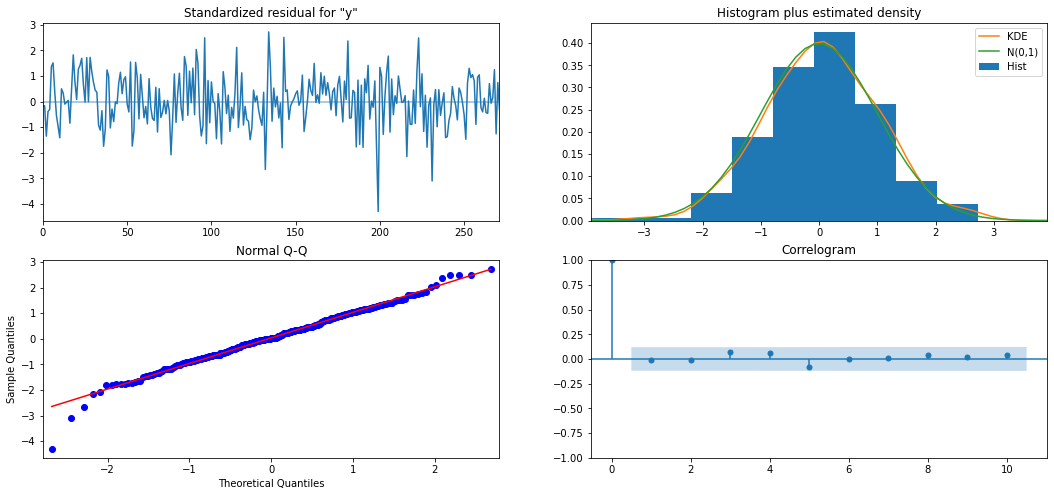

In [85]:
sari_model.plot_diagnostics(figsize=(18, 8))
plt.show()

In [86]:
sari_pred = sari_model.forecast(steps=len(test))
sari_mae = round(mean_absolute_error(test, sari_pred), 3)
sari_mae

0.689

* The MAE got much worse

* From the SARIMA models, we'll stick with the first one

# 3.4.1 Recurrent Neural Network

## Long Short-Term Memory

We will use the LTSM architecture as it is well suited for time-series forecasting

* Has the advantage of dealing with the vanishing gradient issue
* Can find lags of unknown durations that the ARIMA and SARIMA models couldn't




### We'll do a Train, Validate, Test split this time

In [87]:
ml_data = ys_month
p_60 = int(len(ml_data) * 0.6)
p_80 = int(len(ml_data) * 0.8)

train = ml_data[:p_60]
val = ml_data[p_60:p_80]
test = ml_data[p_80:]

In [88]:
# Make the X value of the next day as the y value

X_train, y_train = (train), (train.shift(-1, freq='MS'))
X_val, y_val =(val), (val.shift(-1, freq='MS'))
X_test, y_test =(test), (test.shift(-1, freq='MS'))

In [89]:
# Remove the last X value and the first y value

X_train, y_train = np.array(X_train[:-1]), np.array(y_train[1:])
X_val, y_val =  np.array(X_val[:-1]), np.array(y_val[1:])
X_test, y_test = np.array(X_test[:-1]), np.array(y_test[1:])

In [90]:
# This model requires a 3 dimensional input

X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 1, 1))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(232, 1, 1)
(77, 1, 1)
(77, 1, 1)


In [91]:
## RNN LSTM Model

In [92]:
batch_size = 1
look_back = 1


model = Sequential()
model.add(LSTM(6, batch_input_shape=(batch_size, look_back, 1),
                return_sequences=True, stateful=True))
model.add(LSTM(6, return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), callbacks=es,
                    epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
232/232 - 1s - loss: 29.9952 - val_loss: 1.4718
Epoch 2/100
232/232 - 0s - loss: 11.4563 - val_loss: 1.4387
Epoch 3/100
232/232 - 0s - loss: 4.8041 - val_loss: 4.1566
Epoch 4/100
232/232 - 0s - loss: 2.9162 - val_loss: 6.5953
Epoch 5/100
232/232 - 0s - loss: 2.3054 - val_loss: 8.2264
Epoch 6/100
232/232 - 0s - loss: 2.1277 - val_loss: 9.1925
Epoch 7/100
232/232 - 0s - loss: 2.0783 - val_loss: 9.6745
Epoch 8/100
232/232 - 0s - loss: 2.0632 - val_loss: 9.6031
Epoch 9/100
232/232 - 0s - loss: 2.0057 - val_loss: 8.8539
Epoch 10/100
232/232 - 0s - loss: 1.9221 - val_loss: 8.0343
Epoch 11/100
232/232 - 0s - loss: 1.7728 - val_loss: 4.4906
Epoch 12/100
232/232 - 0s - loss: 1.2555 - val_loss: 2.1484
Epoch 13/100
232/232 - 0s - loss: 0.8243 - val_loss: 1.1753
Epoch 14/100
232/232 - 0s - loss: 0.5535 - val_loss: 0.7371
Epoch 15/100
232/232 - 0s - loss: 0.3925 - val_loss: 0.7444
Epoch 16/100
232/232 - 0s - loss: 0.3014 - val_loss: 0.7891
Epoch 17/100
232/232 - 0s - loss: 0.2401 - val_

Train: 0.812, Val: 1.371


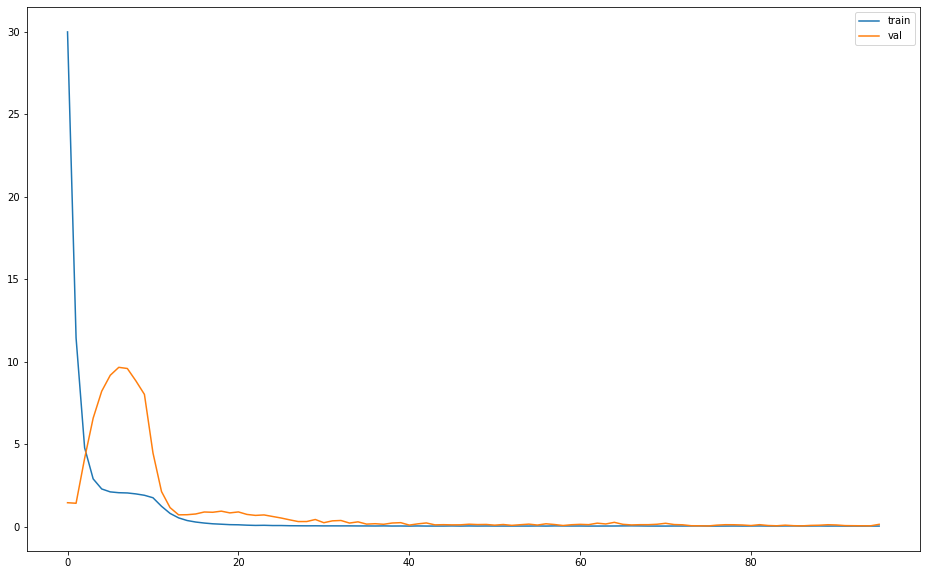

In [93]:
train_acc = model.evaluate(X_train, y_train, verbose=0)
val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [94]:
testPredict = model.predict(X_val, batch_size=batch_size)
trainPredict = model.predict(X_train, batch_size=batch_size)

In [95]:
y_hat =testPredict.reshape(-1)

In [96]:
res =pd.DataFrame(y_val)

In [97]:
res.loc[:,1] = y_hat

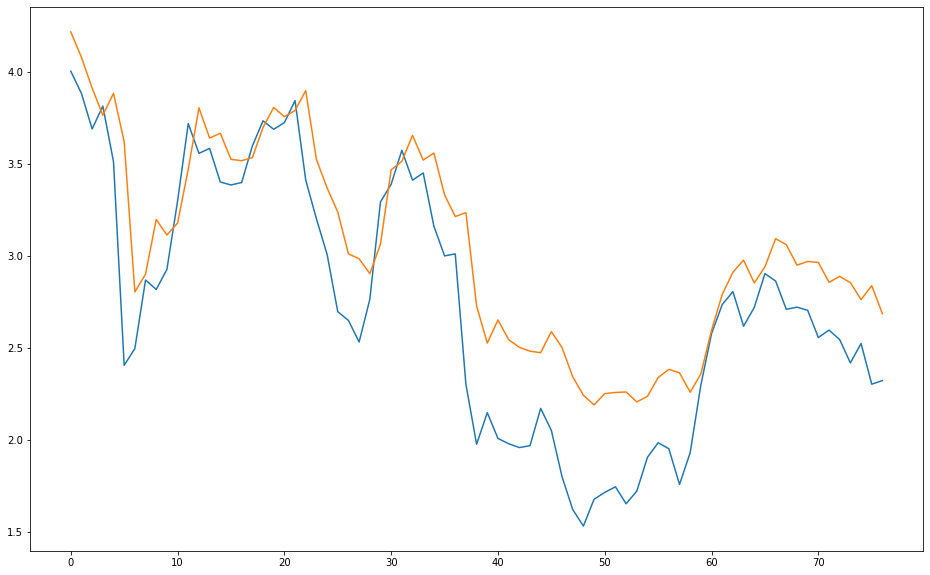

In [98]:
plt.plot(res)

### Since we want to compare the RNN with our previous models, an 80:20 split would work better

In [99]:
# Combine train and val

X_tv =np.concatenate((X_train, X_val), axis=None)
y_tv =np.concatenate((y_train, y_val), axis=None)

In [100]:
X_tv = np.reshape(X_tv, (X_tv.shape[0], 1, 1))

In [101]:
es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

batch_size = 1
look_back = 1


model2 = Sequential()
model2.add(LSTM(6, batch_input_shape=(batch_size, look_back, 1),
                return_sequences=True, stateful=True))
model2.add(LSTM(6, return_sequences=True))
model2.add(Dense(1))
model2.compile(loss='mean_absolute_error', optimizer='adam')
history2 = model2.fit(X_tv, y_tv, 
                    validation_data=(X_test, y_test), callbacks=es,
                    epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
309/309 - 1s - loss: 3.7748 - val_loss: 1.2283
Epoch 2/100
309/309 - 0s - loss: 1.7292 - val_loss: 2.3549
Epoch 3/100
309/309 - 0s - loss: 1.5332 - val_loss: 2.1567
Epoch 4/100
309/309 - 0s - loss: 1.3100 - val_loss: 1.1180
Epoch 5/100
309/309 - 0s - loss: 0.9004 - val_loss: 0.5870
Epoch 6/100
309/309 - 0s - loss: 0.6889 - val_loss: 0.4794
Epoch 7/100
309/309 - 0s - loss: 0.5480 - val_loss: 0.5464
Epoch 8/100
309/309 - 0s - loss: 0.4865 - val_loss: 0.6972
Epoch 9/100
309/309 - 0s - loss: 0.5251 - val_loss: 0.4228
Epoch 10/100
309/309 - 0s - loss: 0.4273 - val_loss: 0.3582
Epoch 11/100
309/309 - 0s - loss: 0.3912 - val_loss: 0.2361
Epoch 12/100
309/309 - 0s - loss: 0.3636 - val_loss: 0.1775
Epoch 13/100
309/309 - 0s - loss: 0.3498 - val_loss: 0.1879
Epoch 14/100
309/309 - 0s - loss: 0.3400 - val_loss: 0.1964
Epoch 15/100
309/309 - 0s - loss: 0.3247 - val_loss: 0.2192
Epoch 16/100
309/309 - 0s - loss: 0.2975 - val_loss: 0.2098
Epoch 17/100
309/309 - 0s - loss: 0.3090 - val_lo

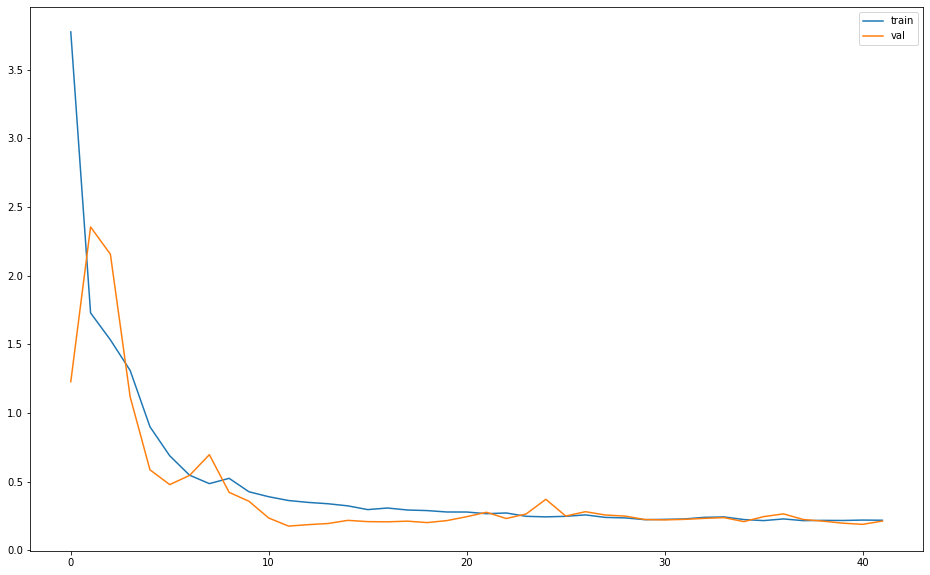

In [102]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()
plt.show()

In [103]:
train_acc = model2.evaluate(X_tv, y_tv, verbose=0)
test_acc = model2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.747, Test: 0.415


Text(0, 0.5, 'Yield')

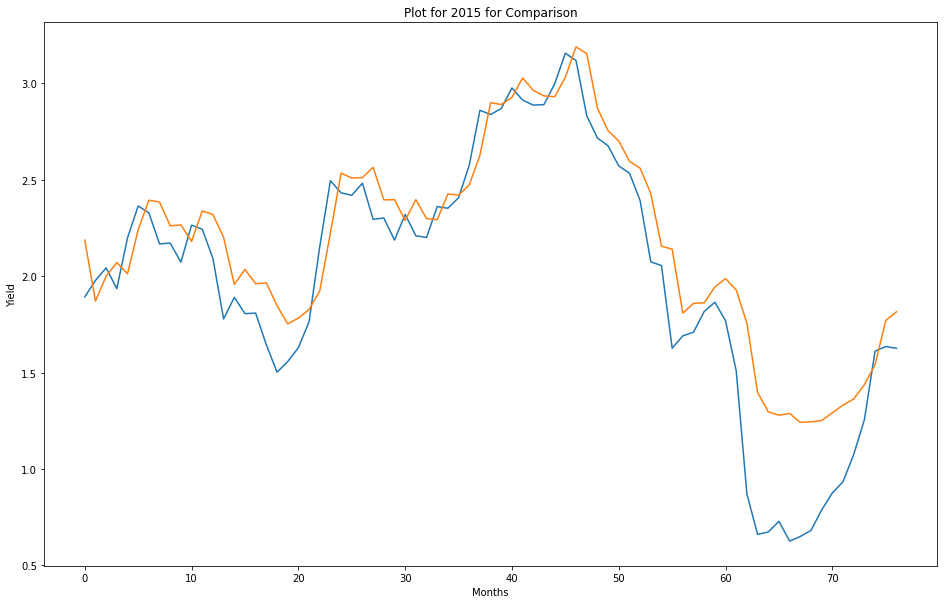

In [104]:
testPredict = model2.predict(X_test, batch_size=batch_size)
y_hat =testPredict.reshape(-1)
res =pd.DataFrame(y_test)
res.loc[:,1] = y_hat
plt.plot(res)
plt.title('Plot for 2015 for Comparison')
plt.xlabel('Months')
plt.ylabel('Yield')

In [105]:
mae_rnn =mean_absolute_error(y_test, y_hat)
print(f'Test split Mean Absolute Error: {mae_rnn}')

Test split Mean Absolute Error: 0.21047764895978605


#### Out of box predictions

This doesn't appear to be an inbuilt feature, so we'll have to do this manually.

In [106]:
x_input = np.array([X_test[-1]])
temp_input=list(x_input)
lst_output=[]
months = 12

for month in range(0, months ,1):
    
    if(len(temp_input)>1):
        x_input=np.array(temp_input[1:])
        #print(x_input)
        x_input = x_input.reshape((1, 1, 1))
        #print(x_input)
        yhat = model2.predict(x_input, verbose=0)
        val = yhat.reshape(-1)
        temp_input.append(val)
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(val)
        
    else:
        x_input = x_input.reshape((1,  1, 1))
        yhat = model2.predict(x_input, verbose=0)
        val = yhat.reshape(-1)
        temp_input.append(val)
        lst_output.append(val)
        
    

forecasts =np.array(lst_output).reshape(-1)

In [107]:
len(forecasts)

12

In [108]:
forecasts

array([1.8364725, 1.9856998, 2.1070788, 2.2158742, 2.3157115, 2.4079578,
       2.4934654, 2.572919 , 2.6469002, 2.715914 , 2.7804022, 2.8407614],
      dtype=float32)

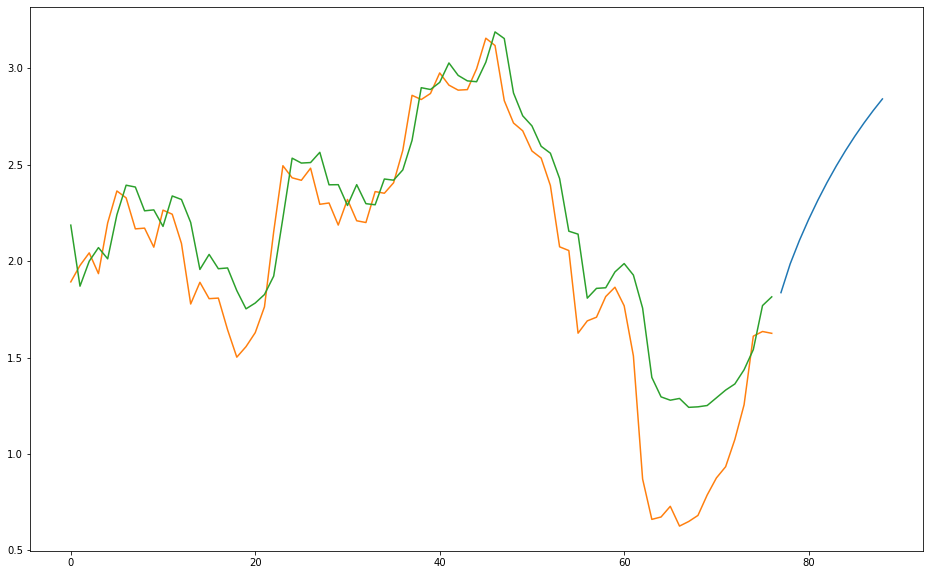

In [109]:
plt.plot(np.arange(77,77+months), forecasts)
plt.plot(res)

In [110]:
forecasts =pd.Series(forecasts)

In [111]:
results =pd.concat([res.loc[:,1], forecasts], ignore_index=True)

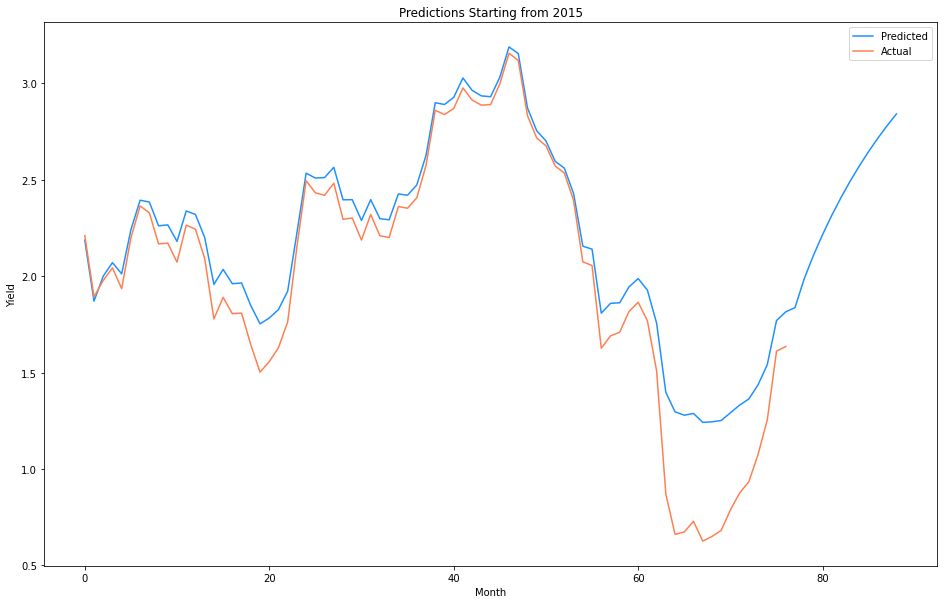

In [112]:
plt.plot(results, label='Predicted', color='dodgerblue')
plt.plot(X_test.reshape(-1), label= 'Actual', color='coral')
plt.xlabel('Month')
plt.ylabel('Yield')
plt.title('Predictions Starting from 2015')
plt.legend()

* Ideally, we would have the confidence interval values for this, but the only way to do that would be the run this model many times and extract the standard deviations.
* Because of the nature of this model, we know that the confidence interval would get wider as we try to predict further into the future.

# 4. Conclusions

## Choosing Model

* Our Recurrent Neural Network model appears to perform the best with the lowest Mean Absolute Error and it doesen't appear to be as sensitive to the downward trend over the years.

* We have a Mean Absolute Error of 0.147 which is quite good considering our mean is 4.49

* It is important to note that for any of these models, the prediction is most likely to be accurate early on.

## Results

* The correlation between the 10 Year Treasury bill and the 30 Year Mortgage rates is 0.99 which is quite high.
* As seen with the out of sample trend for the RNN, the yields for the 10 Year Treasury Bond are expected to increase.  This choice is less risky over the long run since the client will be locked into the lower interest rate.
* Because the interest rates are expected to increase in the future, the best time to take the loan is as soon as possible.
* The short term interest rates have no way to go but up.  This would mean that whenever they do, the interest rate during that period would increase for the client.


## Recommendations

* Choose Fixed Rate Loan over Adjustable Rate Loan
* Take loans as soon as possible
* Prioritize taking loans between May and September

## Next Steps

* Acquire more microeconomic data in order to run multivariate analysis.
* Examine the effects of credit score
* Examine and predict trends in housing prices